# Population Estimates and Components of Change

This notebook analyzes population estimates from the US Census Bureau that include components of change (births, deaths, domestic and foreign migration) over a period of several years for NYC and the NY Metropolitan Area. This version uses vintage 2019 population estimates.

https://www.census.gov/data/tables/time-series/demo/popest/2010s-counties-total.html

https://www.census.gov/data/tables/time-series/demo/popest/2010s-total-metro-and-micro-statistical-areas.html

## Modules, Variables, Functions

In [1]:
%matplotlib inline
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')
import pandas.io.formats.format as pf

# display numbers (floats) with thousand separator
pd.options.display.float_format = '{:,.1f}'.format

# found this hack to format integers for display with thousand separator
# https://stackoverflow.com/questions/29663252/format-pandas-integers-for-display?answertab=active#tab-top
class IntArrayFormatter(pf.GenericArrayFormatter):
    def _format_strings(self):
        formatter = self.formatter or '{:,d}'.format
        fmt_values = [formatter(x) for x in self.values]
        return fmt_values
pf.IntArrayFormatter = IntArrayFormatter


In [2]:
#paths and variables

dir_path = os.getcwd()
data_path=os.path.join(dir_path,'source_data')
out_path=os.path.join(dir_path,'output')
county_file='co-est2019-alldata.csv'
metro_file='cbsa-est2019-alldata.csv'

nyc_counties=['36005','36047','36061','36081','36085']
nyc_metro='35620'
nyc_metro_co=['34003','34013','34017','34019','34023','34025','34027','34029','34031',\
      '34035','34037','34039','36005','36047','36059','36061',\
      '36079','36081','36085','36087','36103','36119','42103']
years=['2010','2011','2012','2013','2014','2015','2016','2017','2018','2019']

#colors=['#73a6dc','#e4e2e1','#98d669']
colors=['#2250a9','#59c134','#e4e2e1']

# county fips and city names - counties home to the 10 largest cities in the US, population > 1 million
cities={'06037':'Los Angeles Co, CA','17031': 'Cook Co, IL (Chicago)','48201': 'Harris Co, TX (Houston)',
        '04013': 'Maricopa Co, AZ (Phoenix)','42101': 'Philadelphia Co, PA', '48029': 'Bexar Co, TX (San Antonio)',
        '06073': 'San Diego Co, CA','48113': 'Dallas Co, TX', '06085': 'Santa Clara Co, CA (San Jose)',
        '36005':'New York City, NY','36047':'New York City, NY','36061':'New York City, NY',
        '36081':'New York City, NY','36085':'New York City, NY'}

# CBSA codes for biggest metro areas, population > 4 million
metros=['35620','31080','16980','19100','26420','47900','33100','37980','12060','38060','14460','41860','40140','19820']


In [3]:
# function to reshape the data: make a row for each year of data

def reshape_dataset(df):
    # list to hold temporary dfs while reshaping
    dfs=[]
    for year in years:
        ixs=[i for i in df.index if year in i]
        yr=df.loc[ixs].reset_index().T
        yr.columns=yr.iloc[0]
        yr.drop(yr.index[0], inplace=True)
        yr.index=[year]
        # strip the year out of the column
        new_names=[n[0:len(n)-4].strip('_') for n in yr.columns]
        # assign new column names for a single year row
        yr.columns=new_names
        # append single year of data to the list 
        dfs.append(yr)
    # concatenate all the years
    reshaped=pd.concat(dfs,sort='True')
    return reshaped

In [4]:
# function to plot components of change stacked bar chart
def plot_pop_change(df):
    leg_names=['Population Change','Net Domestic Migration','Net Foreign Migration','Natural Increase']
    ax=df['NPOPCHG'].plot(x='NPOPCHG', linestyle='-', marker='o', color='#000000')

    df[['DOMMIG','INTMIG','NATINC']].plot(kind='bar',ax=ax, stacked=True, figsize=(8,5),legend=False,color=colors,rot=0)
    ax.get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    
    # change font size on this line
    lgd=plt.legend(leg_names, loc=8,bbox_to_anchor=(0.5, -0.3), ncol=2, prop = {'size':13},frameon=False)
    # ticks labels size
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()
    return ax

In [5]:
# function to plot components of change comparison chart
def plot_components_of_pop_change(df, columns=['DOMESTIC', 'INTERNATIONAL','NATURAL']):
    df.sort_values(by='PCT_CHANGE', inplace=True)
    ax = df[columns].plot(kind='barh', stacked=True,rot=0, color=colors, figsize=(8,6))
    bars=ax.patches
    ax.set_xlabel("(Percentage Indicates Net Change)")
    ax.set_ylabel("")
    
    ax.legend(["Domestic Migration","Foreign Migration", "Natural Increase"], loc=2, ncol=1, fontsize=12, frameon=False)
    ax.get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))
    
    # add pct change as text on the plot
    rects=ax.patches
    labels=df['PCT_CHANGE'].sort_values().tolist()
    
    # there are nrows*columns rectangles; we only need one column as labels
    # start iterating from the third column of the rects
    for rect, label in zip(rects[len(df['PCT_CHANGE'])*2:],labels):
        offset = 5
        bl = rect.get_xy()
        x = rect.get_width() + bl[0]+offset        
        y = 0.5*rect.get_height() + bl[1]
        ax.text(x, y, "%.1f%%" % float(label),va='center', color='#727272', fontweight='bold')
    
    # ticks labels size
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=12)    
    return ax

## County / City Data

### Import and Process All Counties

In [6]:
county_pep=pd.read_csv(os.path.join(data_path,county_file),converters={'STATE':str,'COUNTY':str},encoding='LATIN-1')

In [7]:
#create fips code as unique identifier
county_pep['FIPS']=county_pep.STATE+county_pep.COUNTY
county_pep.set_index('FIPS',inplace=True)
county_pep.head()

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,...,RDOMESTICMIG2019,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019
FIPS,,,,,,,,,,,,,,,,,,,,,
01000,40,3,6,01,000,Alabama,Alabama,"4,779,736","4,780,125","4,785,437",...,1.9,0.6,1.2,1.5,0.6,0.6,0.7,1.1,1.8,2.5
01001,50,3,6,01,001,Alabama,Autauga County,"54,571","54,597","54,773",...,4.8,6.0,-6.2,-3.9,2.0,-1.7,4.8,0.8,0.5,4.6
01003,50,3,6,01,003,Alabama,Baldwin County,"182,265","182,265","183,112",...,24.0,16.6,17.5,22.8,20.2,17.7,21.3,22.4,24.7,24.4
01005,50,3,6,01,005,Alabama,Barbour County,"27,457","27,455","27,327",...,-5.7,0.3,-6.9,-8.1,-5.1,-15.7,-18.2,-25.0,-8.8,-5.2
01007,50,3,6,01,007,Alabama,Bibb County,"22,915","22,915","22,870",...,1.4,-5.0,-3.8,-5.8,1.3,1.3,-0.7,-3.2,-6.9,1.8


In [8]:
#pull out necessary columns and rename them

names=[c for c in county_pep.columns if c.endswith('NAME')]
total_pop=[c for c in county_pep.columns if c.startswith('ESTIMATESBASE') or c.startswith('POPESTIMATE')]
pop_change=[c for c in county_pep.columns if c.startswith('NPOPCHG')]
births=[c for c in county_pep.columns if c.startswith('BIRTHS')]
deaths=[c for c in county_pep.columns if c.startswith('DEATHS')]
nat_inc=[c for c in county_pep.columns if c.startswith('NATURALINC')]
net_int=[c for c in county_pep.columns if c.startswith('INTERNATIONALMIG')]
net_dom=[c for c in county_pep.columns if c.startswith('DOMESTICMIG')]

keep_cols=names+total_pop+pop_change+births+deaths+nat_inc+net_int+net_dom
all_counties=pd.DataFrame(county_pep[keep_cols])

all_counties.columns = all_counties.columns.str.replace('ESTIMATESBASE','BASE')
all_counties.columns = all_counties.columns.str.replace('POPESTIMATE','TOTPOP')
all_counties.columns = all_counties.columns.str.replace('NPOPCHG_','NPOPCHG')
all_counties.columns = all_counties.columns.str.replace('NATURALINC','NATINC')
all_counties.columns = all_counties.columns.str.replace('INTERNATIONALMIG','INTMIG')
all_counties.columns = all_counties.columns.str.replace('DOMESTICMIG','DOMMIG')

all_counties.head()

,STNAME,CTYNAME,BASE2010,TOTPOP2010,TOTPOP2011,TOTPOP2012,TOTPOP2013,TOTPOP2014,TOTPOP2015,TOTPOP2016,...,DOMMIG2010,DOMMIG2011,DOMMIG2012,DOMMIG2013,DOMMIG2014,DOMMIG2015,DOMMIG2016,DOMMIG2017,DOMMIG2018,DOMMIG2019
FIPS,,,,,,,,,,,,,,,,,,,,,
01000,Alabama,Alabama,"4,780,125","4,785,437","4,799,069","4,815,588","4,830,081","4,841,799","4,852,347","4,863,525",...,"1,244","-1,893",-114,"2,297",-959,"-1,544","-2,157","2,298","5,279","9,387"
01001,Alabama,Autauga County,"54,597","54,773","55,227","54,954","54,727","54,893","54,864","55,243",...,147,327,-329,-226,101,-107,266,59,37,270
01003,Alabama,Baldwin County,"182,265","183,112","186,558","190,145","194,885","199,183","202,939","207,601",...,782,"2,899","3,055","4,176","3,864","3,433","4,188","4,619","5,224","5,297"
01005,Alabama,Barbour County,"27,455","27,327","27,341","27,169","26,937","26,755","26,283","25,806",...,-69,13,-176,-210,-142,-430,-492,-649,-231,-141
01007,Alabama,Bibb County,"22,915","22,870","22,745","22,667","22,521","22,553","22,566","22,586",...,-59,-124,-105,-151,16,17,-30,-83,-164,31


### Create NYC Tables

In [9]:
#extract records for NYC counties
nyc_county_data=all_counties.loc[nyc_counties]
nyc_county_data
# write the resulting data out
nyc_county_data.to_csv(os.path.join(out_path,'data','popest2019_nyc_counties.csv'))

In [10]:
#collapse the five counties into a single city value
nyc_total=nyc_county_data.sum(axis=0,numeric_only=True)
nyc_total[0:11]

BASE2010     8,175,031
TOTPOP2010   8,190,209
TOTPOP2011   8,272,948
TOTPOP2012   8,346,693
TOTPOP2013   8,396,091
TOTPOP2014   8,433,806
TOTPOP2015   8,463,049
TOTPOP2016   8,469,153
TOTPOP2017   8,437,478
TOTPOP2018   8,390,081
TOTPOP2019   8,336,817
dtype: int64

### Components Data and Chart

In [11]:
#Pivot the dataframe to create records by year
#Create frame without 2010 records for generating components

nyc_annual=reshape_dataset(nyc_total)
nyc_annual = nyc_annual.reindex(['TOTPOP','BIRTHS','DEATHS','NATINC','INTMIG','DOMMIG','NPOPCHG'], axis=1).astype('int64')
nyc_annual_minus2010=nyc_annual.copy()
nyc_annual_minus2010.drop('2010',inplace=True)

# write the resulting data out
nyc_annual.to_csv(os.path.join(out_path,'data','popest2019_nyc_summary.csv'))

nyc_annual

,TOTPOP,BIRTHS,DEATHS,NATINC,INTMIG,DOMMIG,NPOPCHG
2010,"8,190,209","29,777","12,307","17,470","13,530","-15,775","15,178"
2011,"8,272,948","120,508","52,303","68,205","62,935","-48,550","82,739"
2012,"8,346,693","118,511","50,828","67,683","63,792","-57,383","73,745"
2013,"8,396,091","119,150","53,237","65,913","55,286","-71,612","49,398"
2014,"8,433,806","117,028","52,826","64,202","59,599","-86,157","37,715"
2015,"8,463,049","117,624","53,955","63,669","58,578","-93,191","29,243"
2016,"8,469,153","115,962","53,183","62,779","62,224","-119,076","6,104"
2017,"8,437,478","113,417","53,835","59,582","47,548","-138,997","-31,675"
2018,"8,390,081","109,546","58,986","50,560","38,760","-136,799","-47,397"
2019,"8,336,817","107,203","62,061","45,142","33,818","-132,266","-53,264"


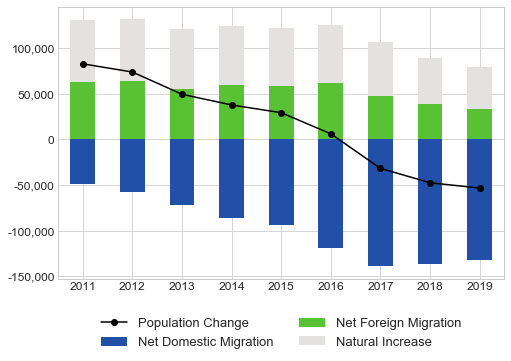

In [12]:
pl1=plot_pop_change(nyc_annual_minus2010)
f1=pl1.get_figure()
f1.savefig(os.path.join(out_path, 'images','nyc_comp_change.png'),bbox_inches='tight')

### Biggest Cities Data and Chart

In [13]:
#Pull out data for the 10 big city / counties, also group to collaspe 5 boroughs into 1 city record
big_cities=all_counties.loc[cities.keys()]
city_names=pd.DataFrame.from_dict(cities,orient='index')
big_cities=big_cities.merge(city_names, left_index=True, right_index=True, how='left').rename(columns={0:'CITYNAME'})
city_group=big_cities.groupby('CITYNAME').sum()
city_group.head()

,BASE2010,TOTPOP2010,TOTPOP2011,TOTPOP2012,TOTPOP2013,TOTPOP2014,TOTPOP2015,TOTPOP2016,TOTPOP2017,TOTPOP2018,...,DOMMIG2010,DOMMIG2011,DOMMIG2012,DOMMIG2013,DOMMIG2014,DOMMIG2015,DOMMIG2016,DOMMIG2017,DOMMIG2018,DOMMIG2019
CITYNAME,,,,,,,,,,,,,,,,,,,,,
"Bexar Co, TX (San Antonio)","1,714,781","1,722,838","1,755,361","1,788,738","1,821,328","1,858,003","1,894,834","1,927,651","1,956,988","1,981,187",...,"3,590","13,832","12,738","13,537","15,455","15,492","12,247","10,806","8,393","7,493"
"Cook Co, IL (Chicago)","5,195,026","5,199,016","5,219,780","5,239,351","5,252,875","5,254,675","5,244,088","5,224,272","5,200,821","5,171,960",...,"-7,911","-31,086","-27,384","-32,192","-45,585","-57,304","-62,019","-65,794","-63,118","-52,810"
"Dallas Co, TX","2,367,430","2,372,993","2,408,697","2,455,930","2,484,486","2,519,410","2,557,830","2,591,488","2,620,154","2,629,350",...,"-2,703",983,"12,017","-5,153","-2,527","-1,581","-5,667","-8,329","-22,391","-24,389"
"Harris Co, TX (Houston)","4,093,176","4,107,666","4,179,568","4,263,094","4,353,187","4,455,994","4,557,846","4,623,960","4,657,972","4,680,045",...,-139,"6,220","15,728","20,567","22,295","17,692","-16,690","-45,399","-43,779","-30,449"
"Los Angeles Co, CA","9,819,968","9,823,246","9,876,482","9,935,375","9,992,484","10,040,072","10,085,416","10,105,708","10,103,711","10,073,906",...,"-21,753","-54,822","-38,825","-45,765","-59,748","-65,098","-79,139","-91,152","-98,218","-100,808"


In [14]:
#Compute change, percent change, and sum of components for plotting

city_totpop=city_group.loc[:,['BASE2010','TOTPOP2019']].copy()
city_totpop['CHANGE']=(city_totpop.TOTPOP2019-city_totpop.BASE2010)
city_totpop['PCT_CHANGE']=((city_totpop.CHANGE / city_totpop.BASE2010)*100.0).round(1)

nat_cols=[c for c in city_group.columns if c.startswith('NATINC')]
city_totpop['NATURAL']=city_group[nat_cols].sum(axis=1)
dom_cols=[c for c in city_group.columns if c.startswith('DOMMIG')]
city_totpop['DOMESTIC']=city_group[dom_cols].sum(axis=1)
int_cols=[c for c in city_group.columns if c.startswith('INTMIG')]
city_totpop['INTERNATIONAL']=city_group[int_cols].sum(axis=1)

city_totpop

,BASE2010,TOTPOP2019,CHANGE,PCT_CHANGE,NATURAL,DOMESTIC,INTERNATIONAL
CITYNAME,,,,,,,
"Bexar Co, TX (San Antonio)","1,714,781","2,003,554","288,773",16.8,"131,611","113,583","42,700"
"Cook Co, IL (Chicago)","5,195,026","5,150,233","-44,793",-0.9,"255,008","-445,203","145,652"
"Dallas Co, TX","2,367,430","2,635,516","268,086",11.3,"218,560","-59,740","110,494"
"Harris Co, TX (Houston)","4,093,176","4,713,325","620,149",15.2,"407,273","-53,954","267,216"
"Los Angeles Co, CA","9,819,968","10,039,107","219,139",2.2,"583,364","-655,328","293,433"
"Maricopa Co, AZ (Phoenix)","3,817,365","4,485,414","668,049",17.5,"231,005","337,398","97,949"
"New York City, NY","8,175,031","8,336,817","161,786",2.0,"565,205","-899,806","496,070"
"Philadelphia Co, PA","1,526,012","1,584,064","58,052",3.8,"72,740","-91,318","77,685"
"San Diego Co, CA","3,095,349","3,338,330","242,981",7.8,"204,933","-66,277","107,098"


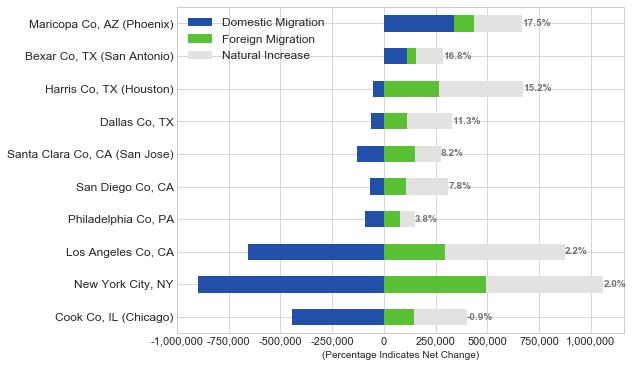

In [15]:
ax_bc=plot_components_of_pop_change(city_totpop)
fig_bc=ax_bc.get_figure()
fig_bc.savefig(os.path.join(out_path, 'images','big_cities_comp.png'),bbox_inches='tight')

In [16]:
#Pull out just the population change columns
city_popchg=city_group.loc[:,'NPOPCHG2011':'NPOPCHG2019'].copy()
city_popchg.head()

,NPOPCHG2011,NPOPCHG2012,NPOPCHG2013,NPOPCHG2014,NPOPCHG2015,NPOPCHG2016,NPOPCHG2017,NPOPCHG2018,NPOPCHG2019
CITYNAME,,,,,,,,,
"Bexar Co, TX (San Antonio)","32,523","33,377","32,590","36,675","36,831","32,817","29,337","24,199","22,367"
"Cook Co, IL (Chicago)","20,764","19,571","13,524","1,800","-10,587","-19,816","-23,451","-28,861","-21,727"
"Dallas Co, TX","35,704","47,233","28,556","34,924","38,420","33,658","28,666","9,196","6,166"
"Harris Co, TX (Houston)","71,902","83,526","90,093","102,807","101,852","66,114","34,012","22,073","33,280"
"Los Angeles Co, CA","53,236","58,893","57,109","47,588","45,344","20,292","-1,997","-29,805","-34,799"


In [17]:
#Transpose the table to get years as rows and places as columns
city_popchg_year=city_popchg.T.copy()
city_popchg_year.index=city_popchg_year.index.str[-4:]
city_popchg_year

CITYNAME,"Bexar Co, TX (San Antonio)","Cook Co, IL (Chicago)","Dallas Co, TX","Harris Co, TX (Houston)","Los Angeles Co, CA","Maricopa Co, AZ (Phoenix)","New York City, NY","Philadelphia Co, PA","San Diego Co, CA","Santa Clara Co, CA (San Jose)"
2011,"32,523","20,764","35,704","71,902","53,236","49,886","82,739","12,183","33,944","26,014"
2012,"33,377","19,571","47,233","83,526","58,893","72,509","73,745","11,358","37,179","25,799"
2013,"32,590","13,524","28,556","90,093","57,109","70,218","49,398","6,489","35,433","28,572"
2014,"36,675","1,800","34,924","102,807","47,588","75,925","37,715","7,147","39,109","25,328"
2015,"36,831","-10,587","38,420","101,852","45,344","79,257","29,243","5,605","31,973","24,532"
2016,"32,817","-19,816","33,658","66,114","20,292","83,238","6,104","4,986","25,239","12,083"
2017,"29,337","-23,451","28,666","34,012","-1,997","71,041","-31,675","4,550","15,148","4,142"
2018,"24,199","-28,861","9,196","22,073","-29,805","75,219","-47,397","2,991","12,624",-173
2019,"22,367","-21,727","6,166","33,280","-34,799","83,011","-53,264",472,"4,469","-4,485"


In [18]:
# Get the last value that represents the max y position, save in dictionary, and modify values for displaying labels
y_pos=dict(city_popchg_year.loc['2019'])
for k,v in y_pos.items():
    print(k,v)
y_pos['Dallas Co, TX']=y_pos['Dallas Co, TX']+4000
y_pos['Philadelphia Co, PA']=y_pos['Philadelphia Co, PA']-1500
y_pos['Santa Clara Co, CA (San Jose)']=y_pos['Santa Clara Co, CA (San Jose)']-3000

Bexar Co, TX (San Antonio) 22367
Cook Co, IL (Chicago) -21727
Dallas Co, TX 6166
Harris Co, TX (Houston) 33280
Los Angeles Co, CA -34799
Maricopa Co, AZ (Phoenix) 83011
New York City, NY -53264
Philadelphia Co, PA 472
San Diego Co, CA 4469
Santa Clara Co, CA (San Jose) -4485


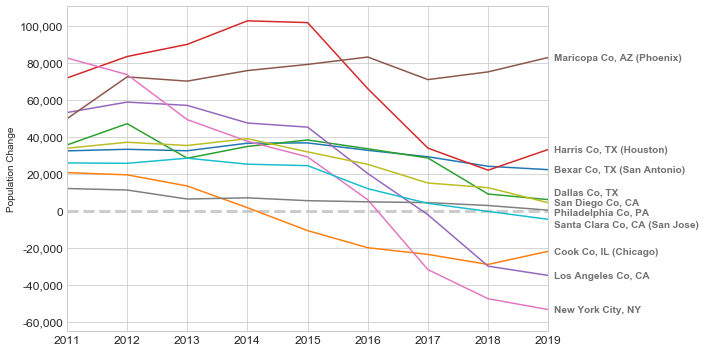

In [19]:
ax=city_popchg_year.plot(kind='line',figsize=(8,5), legend=False)
for k, v in y_pos.items():
    offset = 5
    x = 8.1        
    y = v
    ax.text(x, y, k ,va='center', color='#727272', fontweight='bold')

ax.set_ylabel("Population Change")
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

a = ax.get_ygridlines()
b = a[4]
b.set_linewidth(3)
b.set_linestyle('dashed')
ax.set_xlim(0,8)
ax.set_ylim(bottom=-65000)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12) 
plt.tight_layout()
fig_bp=ax.get_figure()
fig_bp.savefig(os.path.join(out_path, 'images','big_cities_popcnhg.png'),bbox_inches='tight')


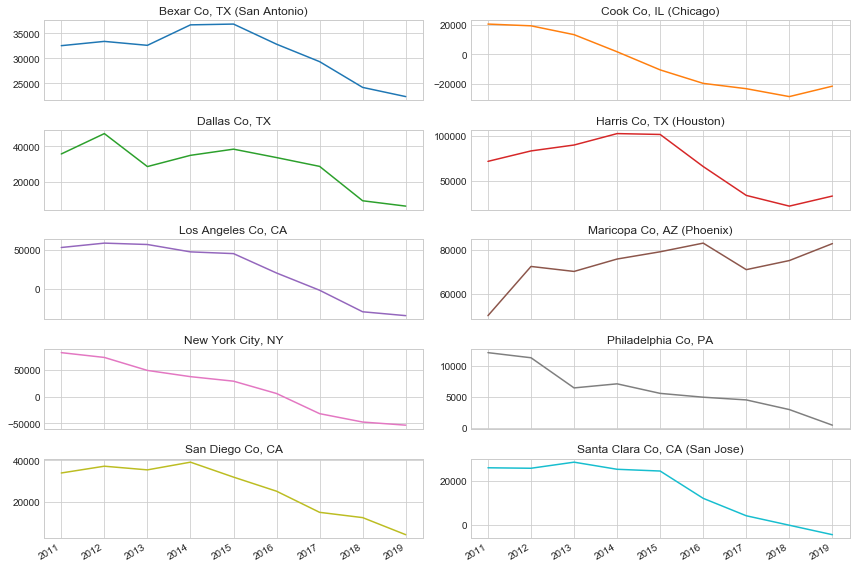

In [20]:
# EXPERIMENT
city_popchg_year.plot(kind = 'line',subplots=True, layout = (5,2), figsize=(12,8),legend=False, title=[c for c in city_popchg_year.columns])
plt.tight_layout()

## Metro Data

### Import and Process All Metros

In [21]:
cbsa_pep=pd.read_csv(os.path.join(data_path,metro_file),converters={'CBSA':str,'MDIV':str, 'STCOU':str},encoding='LATIN-1')
metro_pep=cbsa_pep.loc[cbsa_pep['LSAD']=='Metropolitan Statistical Area'].copy()
metro_pep.set_index('CBSA',inplace=True)
metro_pep.head()

,MDIV,STCOU,NAME,LSAD,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,...,RESIDUAL2010,RESIDUAL2011,RESIDUAL2012,RESIDUAL2013,RESIDUAL2014,RESIDUAL2015,RESIDUAL2016,RESIDUAL2017,RESIDUAL2018,RESIDUAL2019
CBSA,,,,,,,,,,,,,,,,,,,,,
10180,,,"Abilene, TX",Metropolitan Statistical Area,"165,252","165,252","165,585","166,634","167,442","167,473",...,-5,-3,-9,23,-22,-17,-4,-5,-4,-9
10420,,,"Akron, OH",Metropolitan Statistical Area,"703,200","703,196","703,031","703,200","702,109","703,621",...,-33,-12,-48,-87,-115,-48,-17,-27,-18,-22
10500,,,"Albany, GA",Metropolitan Statistical Area,"153,857","154,033","154,145","154,545","153,976","152,667",...,3,-2,29,47,19,22,7,1,-4,1
10540,,,"Albany-Lebanon, OR",Metropolitan Statistical Area,"116,672","116,681","116,891","118,164","118,273","118,405",...,-10,1,-27,-20,-11,0,9,6,11,9
10580,,,"Albany-Schenectady-Troy, NY",Metropolitan Statistical Area,"870,716","870,713","871,082","872,778","874,698","877,065",...,-38,-21,-122,-77,-90,-54,-26,-25,-13,-9


In [22]:
#pull out necessary columns and rename them

names=[c for c in metro_pep.columns if c.endswith('NAME')]
total_pop=[c for c in metro_pep.columns if c.startswith('ESTIMATESBASE') or c.startswith('POPESTIMATE')]
pop_change=[c for c in metro_pep.columns if c.startswith('NPOPCHG')]
births=[c for c in metro_pep.columns if c.startswith('BIRTHS')]
deaths=[c for c in metro_pep.columns if c.startswith('DEATHS')]
nat_inc=[c for c in metro_pep.columns if c.startswith('NATURALINC')]
net_int=[c for c in metro_pep.columns if c.startswith('INTERNATIONALMIG')]
net_dom=[c for c in metro_pep.columns if c.startswith('DOMESTICMIG')]

keep_cols=names+total_pop+pop_change+births+deaths+nat_inc+net_int+net_dom
all_metros=pd.DataFrame(metro_pep[keep_cols])

all_metros.columns = all_metros.columns.str.replace('ESTIMATESBASE','BASE')
all_metros.columns = all_metros.columns.str.replace('POPESTIMATE','TOTPOP')
all_metros.columns = all_metros.columns.str.replace('NPOPCHG_','NPOPCHG')
all_metros.columns = all_metros.columns.str.replace('NATURALINC','NATINC')
all_metros.columns = all_metros.columns.str.replace('INTERNATIONALMIG','INTMIG')
all_metros.columns = all_metros.columns.str.replace('DOMESTICMIG','DOMMIG')

all_metros.head()

,NAME,BASE2010,TOTPOP2010,TOTPOP2011,TOTPOP2012,TOTPOP2013,TOTPOP2014,TOTPOP2015,TOTPOP2016,TOTPOP2017,...,DOMMIG2010,DOMMIG2011,DOMMIG2012,DOMMIG2013,DOMMIG2014,DOMMIG2015,DOMMIG2016,DOMMIG2017,DOMMIG2018,DOMMIG2019
CBSA,,,,,,,,,,,,,,,,,,,,,
10180,"Abilene, TX","165,252","165,585","166,634","167,442","167,473","168,342","169,688","170,017","170,429",...,124,64,-461,"-1,050",-310,159,-710,-593,-49,90
10420,"Akron, OH","703,196","703,031","703,200","702,109","703,621","704,908","704,382","703,524","703,987",...,-727,"-1,861","-2,736",-778,"-1,092","-2,499","-2,875",-881,"-1,044","-1,190"
10500,"Albany, GA","154,033","154,145","154,545","153,976","152,667","151,949","150,387","149,137","148,090",...,-40,-725,"-1,480","-2,237","-1,467","-2,268","-1,812","-1,532",-641,"-1,516"
10540,"Albany-Lebanon, OR","116,681","116,891","118,164","118,273","118,405","119,042","120,236","122,769","125,035",...,74,892,-158,-43,420,"1,012","2,254","1,964","2,198","2,066"
10580,"Albany-Schenectady-Troy, NY","870,713","871,082","872,778","874,698","877,065","878,113","879,085","879,792","882,158",...,-618,"-1,515","-1,478",-759,"-2,553","-2,321","-2,800",-163,"-1,674","-3,375"


### Create NYMA Tables and Plot Components

In [23]:
#Pivot the dataframe to create records by year
#Create frame without 2010 records for generating components

nyma_annual=reshape_dataset(all_metros.loc[nyc_metro,:])
nyma_annual = nyma_annual.reindex(['TOTPOP','BIRTHS','DEATHS','NATINC','INTMIG','DOMMIG','NPOPCHG'], axis=1).astype('int64')
nyma_annual_minus2010=nyma_annual.copy()
nyma_annual_minus2010.drop('2010',inplace=True)

# write the resulting data out
nyma_annual.to_csv(os.path.join(out_path,'data','popest2019_nyma_summary.csv'))

nyma_annual

,TOTPOP,BIRTHS,DEATHS,NATINC,INTMIG,DOMMIG,NPOPCHG
2010,"18,923,407","61,880","31,929","29,951","21,771","-24,080","27,130"
2011,"19,052,774","247,563","135,400","112,163","103,201","-86,058","129,367"
2012,"19,149,689","243,039","131,945","111,094","98,148","-111,866","96,915"
2013,"19,226,449","242,518","138,288","104,230","88,674","-115,496","76,760"
2014,"19,280,929","240,738","134,663","106,075","94,855","-146,454","54,480"
2015,"19,320,968","242,710","138,019","104,691","103,979","-168,893","40,039"
2016,"19,334,778","241,213","136,124","105,089","106,411","-197,939","13,810"
2017,"19,322,607","237,191","140,335","96,856","94,007","-203,208","-12,171"
2018,"19,276,644","232,601","147,412","85,189","67,329","-198,628","-45,963"
2019,"19,216,182","228,660","151,896","76,764","58,630","-196,045","-60,462"


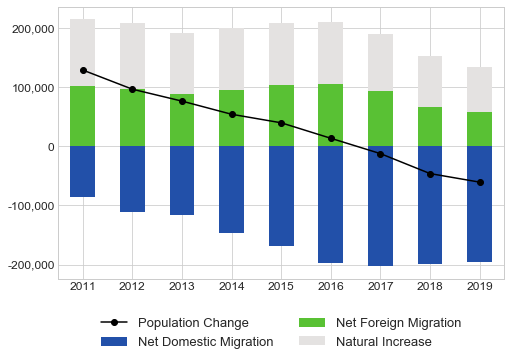

In [24]:
pl2=plot_pop_change(nyma_annual_minus2010)
f2=pl2.get_figure()
f2.savefig(os.path.join(out_path, 'images','nyma_comp_change.png'),bbox_inches='tight')

### Biggest Metros Data and Chart

In [25]:
#Pull out data for the 14 largest metros
big_metros=all_metros.loc[metros]
big_metros.head()

,NAME,BASE2010,TOTPOP2010,TOTPOP2011,TOTPOP2012,TOTPOP2013,TOTPOP2014,TOTPOP2015,TOTPOP2016,TOTPOP2017,...,DOMMIG2010,DOMMIG2011,DOMMIG2012,DOMMIG2013,DOMMIG2014,DOMMIG2015,DOMMIG2016,DOMMIG2017,DOMMIG2018,DOMMIG2019
CBSA,,,,,,,,,,,,,,,,,,,,,
35620,"New York-Newark-Jersey City, NY-NJ-PA","18,896,277","18,923,407","19,052,774","19,149,689","19,226,449","19,280,929","19,320,968","19,334,778","19,322,607",...,"-24,080","-86,058","-111,866","-115,496","-146,454","-168,893","-197,939","-203,208","-198,628","-196,045"
31080,"Los Angeles-Long Beach-Anaheim, CA","12,828,957","12,838,417","12,925,753","13,013,443","13,097,434","13,166,609","13,234,696","13,270,694","13,278,000",...,"-21,601","-49,403","-36,714","-46,864","-68,387","-74,669","-93,204","-109,195","-118,237","-122,166"
16980,"Chicago-Naperville-Elgin, IL-IN-WI","9,461,537","9,470,634","9,500,870","9,528,090","9,550,194","9,560,430","9,552,554","9,533,662","9,514,113",...,"-10,705","-52,010","-49,491","-50,195","-64,813","-81,741","-86,136","-84,976","-83,582","-74,950"
19100,"Dallas-Fort Worth-Arlington, TX","6,366,537","6,392,065","6,510,544","6,644,559","6,753,889","6,889,769","7,042,566","7,194,758","7,337,097",...,"6,384","40,000","53,365","31,241","47,785","60,136","61,567","56,877","45,001","46,601"
26420,"Houston-The Woodlands-Sugar Land, TX","5,920,487","5,947,236","6,056,193","6,183,531","6,328,208","6,500,199","6,671,808","6,806,503","6,900,090",...,"7,097","23,594","39,080","54,761","67,090","62,052","27,109","-9,481","-9,392","7,147"


In [26]:
#Compute change, percent change, and sum of components for plotting

metro_totpop=big_metros.loc[:,['NAME','BASE2010','TOTPOP2019']].copy()
metro_totpop['CHANGE']=(metro_totpop.TOTPOP2019-metro_totpop.BASE2010)
metro_totpop['PCT_CHANGE']=((metro_totpop.CHANGE / metro_totpop.BASE2010)*100.0).round(1)

nat_cols=[c for c in big_metros.columns if c.startswith('NATINC')]
metro_totpop['NATURAL']=big_metros[nat_cols].sum(axis=1)
dom_cols=[c for c in big_metros.columns if c.startswith('DOMMIG')]
metro_totpop['DOMESTIC']=big_metros[dom_cols].sum(axis=1)
int_cols=[c for c in big_metros.columns if c.startswith('INTMIG')]
metro_totpop['INTERNATIONAL']=big_metros[int_cols].sum(axis=1)
metro_totpop.set_index('NAME', inplace=True)

metro_totpop

,BASE2010,TOTPOP2019,CHANGE,PCT_CHANGE,NATURAL,DOMESTIC,INTERNATIONAL
NAME,,,,,,,
"New York-Newark-Jersey City, NY-NJ-PA","18,896,277","19,216,182","319,905",1.7,"932,102","-1,448,667","837,005"
"Los Angeles-Long Beach-Anaheim, CA","12,828,957","13,214,799","385,842",3.0,"753,642","-740,440","377,442"
"Chicago-Naperville-Elgin, IL-IN-WI","9,461,537","9,458,539","-2,998",-0.0,"438,246","-638,599","197,093"
"Dallas-Fort Worth-Arlington, TX","6,366,537","7,573,136","1,206,599",19.0,"517,590","448,957","237,927"
"Houston-The Woodlands-Sugar Land, TX","5,920,487","7,066,141","1,145,654",19.4,"540,027","269,057","333,553"
"Washington-Arlington-Alexandria, DC-VA-MD-WV","5,649,688","6,280,487","630,799",11.2,"428,108","-126,308","326,958"
"Miami-Fort Lauderdale-Pompano Beach, FL","5,566,274","6,166,488","600,214",10.8,"178,095","-192,580","615,283"
"Philadelphia-Camden-Wilmington, PA-NJ-DE-MD","5,965,677","6,102,434","136,757",2.3,"155,315","-171,591","156,632"
"Atlanta-Sandy Springs-Alpharetta, GA","5,286,718","6,020,364","733,646",13.9,"343,765","245,029","144,048"


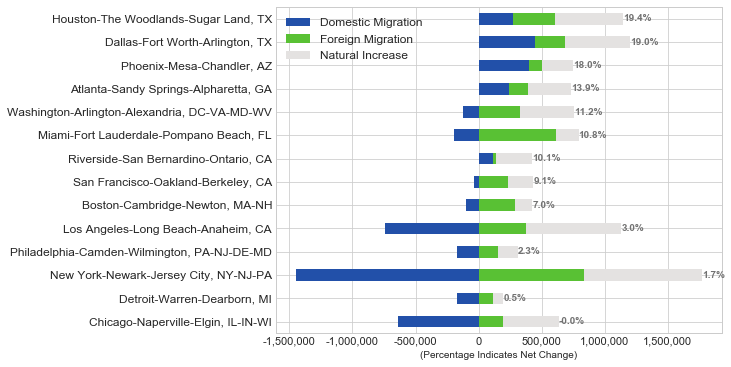

In [27]:
ax_bm=plot_components_of_pop_change(metro_totpop)
fig_bm=ax_bm.get_figure()
fig_bm.savefig(os.path.join(out_path, 'images','big_metros_comp.png'),bbox_inches='tight')

In [28]:
#Pull out just the population change columns
cols=[c for c in metro_pep.columns if c.startswith('NPOPCHG') and not c.endswith('2010')]
cols.insert(0,'NAME')
metro_popchg=big_metros.loc[:, cols].copy()
metro_popchg.set_index('NAME', inplace=True)
metro_popchg.head()

,NPOPCHG2011,NPOPCHG2012,NPOPCHG2013,NPOPCHG2014,NPOPCHG2015,NPOPCHG2016,NPOPCHG2017,NPOPCHG2018,NPOPCHG2019
NAME,,,,,,,,,
"New York-Newark-Jersey City, NY-NJ-PA","129,367","96,915","76,760","54,480","40,039","13,810","-12,171","-45,963","-60,462"
"Los Angeles-Long Beach-Anaheim, CA","87,336","87,690","83,991","69,175","68,087","35,998","7,306","-28,121","-35,080"
"Chicago-Naperville-Elgin, IL-IN-WI","30,236","27,220","22,104","10,236","-7,876","-18,892","-19,549","-29,955","-25,619"
"Dallas-Fort Worth-Arlington, TX","118,479","134,015","109,330","135,880","152,797","152,192","142,339","118,659","117,380"
"Houston-The Woodlands-Sugar Land, TX","108,957","127,338","144,677","171,991","171,609","134,695","93,587","76,057","89,994"


In [29]:
#Transpose the table to get years as rows and places as columns
#ALSO - filter out some rows to get 10 metros instead of 14
metro_popchg_year=metro_popchg.iloc[0:10].T.copy()
#metro_popchg_year=metro_popchg.T.copy()

metro_popchg_year.index=metro_popchg_year.index.str[-4:]
metro_popchg_year

NAME,"New York-Newark-Jersey City, NY-NJ-PA","Los Angeles-Long Beach-Anaheim, CA","Chicago-Naperville-Elgin, IL-IN-WI","Dallas-Fort Worth-Arlington, TX","Houston-The Woodlands-Sugar Land, TX","Washington-Arlington-Alexandria, DC-VA-MD-WV","Miami-Fort Lauderdale-Pompano Beach, FL","Philadelphia-Camden-Wilmington, PA-NJ-DE-MD","Atlanta-Sandy Springs-Alpharetta, GA","Phoenix-Mesa-Chandler, AZ"
2011,"129,367","87,336","30,236","118,479","108,957","103,828","84,877","25,333","63,864","48,833"
2012,"96,915","87,690","27,220","134,015","127,338","96,623","77,472","20,384","78,011","76,719"
2013,"76,760","83,991","22,104","109,330","144,677","84,370","77,011","13,518","66,057","73,365"
2014,"54,480","69,175","10,236","135,880","171,991","68,633","71,104","16,248","82,674","85,849"
2015,"40,039","68,087","-7,876","152,797","171,609","62,005","75,277","10,434","92,844","89,549"
2016,"13,810","35,998","-18,892","152,192","134,695","55,351","86,551","9,845","101,917","94,817"
2017,"-12,171","7,306","-19,549","142,339","93,587","62,040","62,469","11,861","84,467","85,412"
2018,"-45,963","-28,121","-29,955","118,659","76,057","36,500","25,682","12,686","72,871","90,461"
2019,"-60,462","-35,080","-25,619","117,380","89,994","32,646","22,651","11,226","75,061","98,994"


In [30]:
# Get the last value that represents the max y position, save in dictionary
# Modifications for displaying labels wasn't necessary in this case
y_pos=dict(metro_popchg_year.loc['2019'])
for k,v in y_pos.items():
    print(k,v)

New York-Newark-Jersey City, NY-NJ-PA -60462
Los Angeles-Long Beach-Anaheim, CA -35080
Chicago-Naperville-Elgin, IL-IN-WI -25619
Dallas-Fort Worth-Arlington, TX 117380
Houston-The Woodlands-Sugar Land, TX 89994
Washington-Arlington-Alexandria, DC-VA-MD-WV 32646
Miami-Fort Lauderdale-Pompano Beach, FL 22651
Philadelphia-Camden-Wilmington, PA-NJ-DE-MD 11226
Atlanta-Sandy Springs-Alpharetta, GA 75061
Phoenix-Mesa-Chandler, AZ 98994


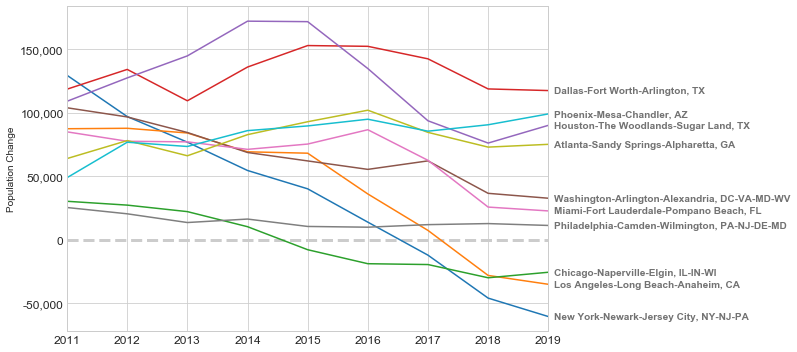

In [31]:
ax=metro_popchg_year.plot(kind='line',figsize=(8,5), legend=False)
for k, v in y_pos.items():
    offset = 5
    x = 8.1        
    y = v
    ax.text(x, y, k ,va='center', color='#727272', fontweight='bold')

ax.set_ylabel("Population Change")
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

a = ax.get_ygridlines()
b = a[2]
b.set_linewidth(3)
b.set_linestyle('dashed')
ax.set_xlim(0,8)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12) 
plt.tight_layout()
fig_mp=ax.get_figure()
fig_mp.savefig(os.path.join(out_path, 'images','big_metros_popcnhg.png'),bbox_inches='tight')

## Summary Table

In [32]:
nyc=city_totpop.loc['New York City, NY',:]
nyma=metro_totpop.loc['New York-Newark-Jersey City, NY-NJ-PA',:]
sumtab=pd.concat([nyc,nyma], axis=1).T.astype({'BASE2010': 'int64','TOTPOP2019':'int64', 'CHANGE':'int64', 
                                              'NATURAL':'int64','DOMESTIC':'int64','INTERNATIONAL':'int64'})
sumtab

,BASE2010,TOTPOP2019,CHANGE,PCT_CHANGE,NATURAL,DOMESTIC,INTERNATIONAL
"New York City, NY","8,175,031","8,336,817","161,786",2.0,"565,205","-899,806","496,070"
"New York-Newark-Jersey City, NY-NJ-PA","18,896,277","19,216,182","319,905",1.7,"932,102","-1,448,667","837,005"


In [33]:
print(sumtab.to_latex())

\begin{tabular}{lrrrrrrr}
\toprule
{} &   BASE2010 &  TOTPOP2019 &  CHANGE &  PCT\_CHANGE &  NATURAL &   DOMESTIC &  INTERNATIONAL \\
\midrule
New York City, NY                     &  8,175,031 &   8,336,817 & 161,786 &         2.0 &  565,205 &   -899,806 &        496,070 \\
New York-Newark-Jersey City, NY-NJ-PA & 18,896,277 &  19,216,182 & 319,905 &         1.7 &  932,102 & -1,448,667 &        837,005 \\
\bottomrule
\end{tabular}



## Historical Plot

In [34]:
earlier_file='co-est00int-tot.csv'

In [35]:
county2000=pd.read_csv(os.path.join(data_path,earlier_file),converters={'STATE':str,'COUNTY':str},encoding='LATIN-1')
county2000.head()

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,ESTIMATESBASE2000,POPESTIMATE2000,POPESTIMATE2001,POPESTIMATE2002,POPESTIMATE2003,POPESTIMATE2004,POPESTIMATE2005,POPESTIMATE2006,POPESTIMATE2007,POPESTIMATE2008,POPESTIMATE2009,CENSUS2010POP,POPESTIMATE2010
0,40,3,6,1,0,Alabama,Alabama,"4,447,207","4,452,173","4,467,634","4,480,089","4,503,491","4,530,729","4,569,805","4,628,981","4,672,840","4,718,206","4,757,938","4,779,736","4,785,298"
1,50,3,6,1,1,Alabama,Autauga County,"43,751","44,021","44,889","45,909","46,800","48,366","49,676","51,328","52,405","53,277","54,135","54,571","54,632"
2,50,3,6,1,3,Alabama,Baldwin County,"140,416","141,342","144,875","147,957","151,509","156,266","162,183","168,121","172,404","175,827","179,406","182,265","183,195"
3,50,3,6,1,5,Alabama,Barbour County,"29,042","29,015","28,863","28,653","28,594","28,287","28,027","27,861","27,757","27,808","27,657","27,457","27,411"
4,50,3,6,1,7,Alabama,Bibb County,"19,856","19,913","21,028","21,199","21,399","21,721","22,042","22,099","22,438","22,705","22,941","22,915","22,867"


In [36]:
#drop states, fix fips, create stco fips
county2000.drop(county2000[county2000.SUMLEV==40].index, inplace=True)
county2000.loc[county2000['STATE'].str.len()==1,'STATE'] = '0'+county2000['STATE']
county2000.loc[county2000['COUNTY'].str.len()==1,'COUNTY'] = '00'+county2000['COUNTY']
county2000.loc[county2000['COUNTY'].str.len()==2,'COUNTY'] = '0'+county2000['COUNTY']

county2000['FIPS']=county2000.STATE+county2000.COUNTY
county2000.set_index('FIPS',inplace=True)
county2000.head()

,SUMLEV,REGION,DIVISION,STATE,COUNTY,STNAME,CTYNAME,ESTIMATESBASE2000,POPESTIMATE2000,POPESTIMATE2001,POPESTIMATE2002,POPESTIMATE2003,POPESTIMATE2004,POPESTIMATE2005,POPESTIMATE2006,POPESTIMATE2007,POPESTIMATE2008,POPESTIMATE2009,CENSUS2010POP,POPESTIMATE2010
FIPS,,,,,,,,,,,,,,,,,,,,
01001,50,3,6,01,001,Alabama,Autauga County,"43,751","44,021","44,889","45,909","46,800","48,366","49,676","51,328","52,405","53,277","54,135","54,571","54,632"
01003,50,3,6,01,003,Alabama,Baldwin County,"140,416","141,342","144,875","147,957","151,509","156,266","162,183","168,121","172,404","175,827","179,406","182,265","183,195"
01005,50,3,6,01,005,Alabama,Barbour County,"29,042","29,015","28,863","28,653","28,594","28,287","28,027","27,861","27,757","27,808","27,657","27,457","27,411"
01007,50,3,6,01,007,Alabama,Bibb County,"19,856","19,913","21,028","21,199","21,399","21,721","22,042","22,099","22,438","22,705","22,941","22,915","22,867"
01009,50,3,6,01,009,Alabama,Blount County,"50,982","51,107","51,845","52,551","53,457","54,124","54,624","55,485","56,240","57,055","57,341","57,322","57,338"


In [37]:
names=[c for c in county2000 if c.endswith('NAME')]
total_pop=[c for c in county2000.columns if c.startswith('POPESTIMATE')]

keep_cols=names+total_pop
all_counties2000=pd.DataFrame(county2000[keep_cols])

all_counties2000.columns = all_counties2000.columns.str.replace('POPESTIMATE','')
all_counties2000.drop(['2010'], axis=1, inplace=True)

all_counties2000.head()

,STNAME,CTYNAME,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009
FIPS,,,,,,,,,,,,
01001,Alabama,Autauga County,"44,021","44,889","45,909","46,800","48,366","49,676","51,328","52,405","53,277","54,135"
01003,Alabama,Baldwin County,"141,342","144,875","147,957","151,509","156,266","162,183","168,121","172,404","175,827","179,406"
01005,Alabama,Barbour County,"29,015","28,863","28,653","28,594","28,287","28,027","27,861","27,757","27,808","27,657"
01007,Alabama,Bibb County,"19,913","21,028","21,199","21,399","21,721","22,042","22,099","22,438","22,705","22,941"
01009,Alabama,Blount County,"51,107","51,845","52,551","53,457","54,124","54,624","55,485","56,240","57,055","57,341"


In [38]:
nyc_county2000=all_counties2000.loc[nyc_counties]
nyc_county2000

,STNAME,CTYNAME,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009
FIPS,,,,,,,,,,,,
36005,New York,Bronx County,"1,334,319","1,346,555","1,358,739","1,362,373","1,358,963","1,351,736","1,348,164","1,354,056","1,363,488","1,376,261"
36047,New York,Kings County,"2,467,006","2,477,252","2,480,559","2,472,999","2,459,094","2,445,809","2,436,132","2,441,324","2,460,361","2,487,751"
36061,New York,New York County,"1,540,547","1,555,729","1,555,382","1,562,154","1,569,947","1,573,573","1,578,171","1,581,402","1,587,022","1,583,431"
36081,New York,Queens County,"2,230,501","2,231,316","2,224,507","2,214,608","2,198,516","2,185,222","2,173,862","2,177,351","2,193,623","2,217,166"
36085,New York,Richmond County,"445,235","448,961","452,813","455,939","456,846","457,028","457,577","459,642","463,701","466,965"


In [39]:
nyc_total2000=nyc_county2000.sum(axis=0,numeric_only=True)
nyc_total2000

2000   8,017,608
2001   8,059,813
2002   8,072,000
2003   8,068,073
2004   8,043,366
2005   8,013,368
2006   7,993,906
2007   8,013,775
2008   8,068,195
2009   8,131,574
dtype: int64

In [40]:
nyc_total2010=nyc_annual['TOTPOP']
nyc_total2010

2010   8,190,209
2011   8,272,948
2012   8,346,693
2013   8,396,091
2014   8,433,806
2015   8,463,049
2016   8,469,153
2017   8,437,478
2018   8,390,081
2019   8,336,817
Name: TOTPOP, dtype: int64

In [41]:
nyc_twenty=pd.concat([nyc_total2000,nyc_total2010])
nyc_twenty

2000   8,017,608
2001   8,059,813
2002   8,072,000
2003   8,068,073
2004   8,043,366
2005   8,013,368
2006   7,993,906
2007   8,013,775
2008   8,068,195
2009   8,131,574
2010   8,190,209
2011   8,272,948
2012   8,346,693
2013   8,396,091
2014   8,433,806
2015   8,463,049
2016   8,469,153
2017   8,437,478
2018   8,390,081
2019   8,336,817
dtype: int64

In [42]:
nyma_county2000=all_counties2000.loc[nyc_metro_co]
nyma_county2000.head()

,STNAME,CTYNAME,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009
FIPS,,,,,,,,,,,,
34003,New Jersey,Bergen County,"885,180","888,782","890,647","892,214","893,378","891,446","889,406","890,817","895,328","900,319"
34013,New Jersey,Essex County,"792,253","794,312","795,625","795,167","791,305","786,341","781,027","778,996","778,165","781,943"
34017,New Jersey,Hudson County,"610,135","616,629","615,554","614,813","614,607","614,664","613,577","613,637","619,533","628,572"
34019,New Jersey,Hunterdon County,"122,579","124,500","125,892","126,935","127,583","128,072","128,535","128,568","128,449","128,364"
34023,New Jersey,Middlesex County,"752,880","761,770","769,280","775,973","781,582","787,329","786,890","792,137","799,191","805,204"


In [43]:
nyma_total2000=nyma_county2000.sum(axis=0,numeric_only=True)
nyma_total2010=nyma_annual['TOTPOP']
nyma_twenty=pd.concat([nyma_total2000,nyma_total2010])
nyma_twenty

2000   18,356,204
2001   18,476,764
2002   18,554,586
2003   18,598,803
2004   18,597,871
2005   18,568,830
2006   18,538,752
2007   18,572,325
2008   18,672,355
2009   18,800,157
2010   18,923,407
2011   19,052,774
2012   19,149,689
2013   19,226,449
2014   19,280,929
2015   19,320,968
2016   19,334,778
2017   19,322,607
2018   19,276,644
2019   19,216,182
dtype: int64

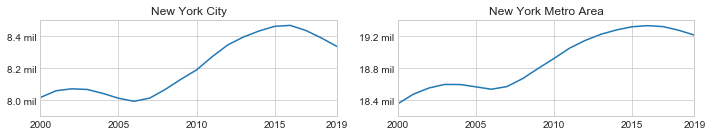

In [44]:
yearticks=[0,5,10,15,19]
yearlabels=[2000,2005,2010,2015,2019]

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10,2))
nyc_twenty.plot(ax=ax1, legend=False)
ax1.set_xlim(0,19)
ax1.set_xticks(yearticks)
ax1.set_xticklabels(yearlabels)
ax1.set_ylim(7900000, 8500000)
ax1.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x/1000000) + ' mil'))
ax1.set_title('New York City')
 

nyma_twenty.plot(ax=ax2, legend=False)
ax2.set_xlim(0,19)
ax2.set_xticks(yearticks)
ax2.set_xticklabels(yearlabels)
ax2.set_ylim(18200000, 19400000)
ax2.yaxis.set_major_locator(plt.MaxNLocator(3))
ax2.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.1f}'.format(x/1000000) + ' mil'))
ax2.set_title('New York Metro Area')
plt.tight_layout()

plt.savefig(os.path.join(out_path, 'images','historical_popchng.png'),bbox_inches='tight')

